In [72]:
import pathlib
from tqdm import tqdm
import tqdm
import pandas as pd
import pickle as pkl
import numpy as np

import xarray as xr
import time

import matplotlib.pyplot as plt
import matplotlib.cm as cm
from mpl_toolkits.axes_grid1 import make_axes_locatable

import scipy
import scipy.stats as st
import os
import copy
import sys
# Import these costom functions from the toolbox
sys.path.insert(1, './tools/')
import metrics
import signatures
import analysis_tools

from sklearn.metrics import r2_score
from sklearn.model_selection import KFold
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

In [2]:
# NOTEBOOK SETUP.
# CHOSE OPTIONS, PATHS, DATE RANGES, ETC. HERE IN THIS CELL

# Options for what to calculate
# Calulations will be saved to pkl
# If False, will load in pkl files
######################################
calculate_metric_dictionary = False #
calculate_flow_categories = False   #
calculate_metric_matrix = False     #
######################################

val_start='10/01/1989'
val_end='09/30/1999'
date_range = pd.date_range(start=val_start, end=val_end)

# Specifics about the analysis to use. 
all_metrics = ['NSE', 'Alpha-NSE', 'Pearson-r', 'Beta-NSE', 'FHV', 'FMS', 'FLV', 'Peak-Timing']
use_metrics = ['NSE', 'Beta-NSE', 'Peak-Timing']
metric_names = ['Nash-Sutcliffe Efficiency', 'Total bias', 'Peak timing error']
short_metric_names = ['NSE', 'Bias', 'Timing']
use_metric_names = ['Nash-Sutcliffe Efficiency', 'Total bias', 'Peak timing error']
use_metric_locs = [0,3,7]
# Plotting parameters for the metrics defined above.
disp_bounds = [(-0,1), (-0.2,0.1), (0,2)]
diff_bounds = [1, 0.2, 2]
optimal = [1, 0, 0]
disp_colors = {'base_model':'PRGn', 'lagged_streamflow_both':'PRGn'} 

# local directory with all data
# not included in github
data_dir = "./data/"
run_dir = "/home/gsnearing/projects/data_assimilation/runs/"

In [40]:
if False: # Open the attributes set up to do regression
    openthis = data_dir+'camels_attributes_v2.0/camels_attributes_v2.0_Regression.csv'
    attributes = pd.read_csv(openthis, sep=',', index_col='gauge_id')
else: # Open a slightly more extrnsive data set.
    openthis = data_dir+'camels_attributes_v2.0/camels_attributes_v2.0.csv'
    attributes = pd.read_csv(openthis, sep=';', index_col='gauge_id')

# Catchment attributes and hydrologic signatures that are not useful
drop_these = ['high_prec_timing','root_depth_50', 'root_depth_99','zero_q_freq','water_frac','organic_frac',
              'low_prec_timing', 'geol_1st_class','dom_land_cover','other_frac']
    
# Add the basin ID as a 8 element string with a leading zero if neccessary
basin_id_str = []
for a in attributes.index.values:
    basin_id_str.append(str(a).zfill(8))
attributes['basin_id_str'] = basin_id_str

# These are bad for the regression analysis.
attributes = attributes.drop(drop_these, axis=1)
df = copy.deepcopy(attributes)

In [41]:
df = df.dropna(axis=1)

In [43]:
# Get the hydrologic units for each basin.
with open(data_dir + 'usgs_site_info.csv', 'r') as f:
    usgs_sites = pd.read_csv(f, skiprows=24, index_col='site_no')
usgs_idx_int = []
for idx in usgs_sites.index.values:
    usgs_idx_int.append(int(idx))
usgs_sites.reindex(usgs_idx_int)
usgs_sites = usgs_sites.reindex(usgs_idx_int)
basin_hydro_unit = []
for b in attributes.basin_id_str.values:
    huc_cd = usgs_sites.loc[int(b),'huc_cd']
    hu = '{:08d}'.format(huc_cd)
    basin_hydro_unit.append(hu[0:2])
attributes['basin_hydro_unit'] = basin_hydro_unit

In [44]:
results = {}
with open(run_dir+"simulation/simulation_0_0206_025210/test/model_epoch030/"+"test_results.p", "rb") as fb:
    results['sim'] = pkl.load(fb)
with open(run_dir+"simulation/assimilation/0.0_1_0/test/model_epoch030/"+"test_results.p", "rb") as fb:
    results['da'] = pkl.load(fb)
with open(run_dir+"autoregression_50_holdout/test/0.0_1_0/test/model_epoch030/"+"test_results.p", "rb") as fb:
    results['ar'] = pkl.load(fb)


In [96]:
static_attributes = ['elev_mean','slope_mean','area_gages2',
'frac_forest','lai_max','lai_diff','gvf_max',
'gvf_diff','soil_depth_pelletier','soil_depth_statsgo','soil_porosity',
'soil_conductivity','max_water_content','sand_frac','silt_frac','clay_frac',
'carbonate_rocks_frac','geol_permeability','p_mean','pet_mean','aridity',
'frac_snow','high_prec_freq','high_prec_dur','low_prec_freq','low_prec_dur']


In [45]:
basin_list = results['sim'].keys()

In [46]:
plot_lats = []
plot_lons = []
for i, b in enumerate(basin_list):
    plot_lats.append(attributes.loc[int(b),'gauge_lat'])
    plot_lons.append(attributes.loc[int(b),'gauge_lon'])
plot_lats = np.array(plot_lats)
plot_lons = np.array(plot_lons)

In [47]:
df = df.set_index('basin_id_str').loc[basin_list,:]

In [48]:
df['nse_sim'] = np.nan
df['nse_ar'] = np.nan
df['nse_da'] = np.nan
df['nse_ar-sim'] = np.nan
df['nse_da-sim'] = np.nan
df['nse_da-ar'] = np.nan

In [49]:
for basin in basin_list:
#     df['nse_sim'] = metrics.nse(results['sim'][basin]['1D']['xr']['QObs(mm/d)_obs'], 
#                                 results['sim'][basin]['1D']['xr']['QObs(mm/d)_sim'])
    df.loc[basin,'nse_sim'] = results['sim'][basin]['1D']['NSE']
    df.loc[basin,'nse_ar'] = results['ar'][basin]['1D']['NSE']
    df.loc[basin,'nse_da'] = results['da'][basin]['1D']['NSE']
    df.loc[basin,'nse_ar-sim'] = results['ar'][basin]['1D']['NSE'] - results['sim'][basin]['1D']['NSE']
    df.loc[basin,'nse_da-sim'] = results['da'][basin]['1D']['NSE'] - results['sim'][basin]['1D']['NSE']
    df.loc[basin,'nse_da-ar'] = results['da'][basin]['1D']['NSE'] - results['ar'][basin]['1D']['NSE']

In [50]:
df.columns.values

array(['p_mean', 'pet_mean', 'p_seasonality', 'frac_snow', 'aridity',
       'high_prec_freq', 'high_prec_dur', 'low_prec_freq', 'low_prec_dur',
       'glim_1st_class_frac', 'glim_2nd_class_frac',
       'carbonate_rocks_frac', 'geol_permeability', 'frac_forest',
       'lai_max', 'lai_diff', 'gvf_max', 'gvf_diff',
       'dom_land_cover_frac', 'soil_depth_pelletier',
       'soil_depth_statsgo', 'soil_porosity', 'soil_conductivity',
       'max_water_content', 'sand_frac', 'silt_frac', 'clay_frac',
       'gauge_lat', 'gauge_lon', 'elev_mean', 'slope_mean', 'area_gages2',
       'area_geospa_fabric', 'baseflow_index', 'nse_sim', 'nse_ar',
       'nse_da', 'nse_ar-sim', 'nse_da-sim', 'nse_da-ar'], dtype=object)

In [133]:
# Random Forest Regression in a K-fold loop
def cross_val_rf(X,y,feature_list,kf,ynormal=False,
                 n_estimators=10,random_state=42,
                 criterion='mse', min_samples_leaf=1, min_samples_split=2, max_depth=None,
                 min_weight_fraction_leaf=0, feature_list_short=[], title='scatterplottitle', filename=None):

    if len(feature_list_short) > 1:
        index_labs = feature_list_short
    else:
        index_labs = feature_list
    feature_importances = pd.DataFrame(index=index_labs, columns=['total_importance'])
    for iF, F in enumerate(feature_importances.index.values):
        feature_importances.loc[F, 'total_importance'] = 0
    
    rmse_list = []
    r2_list = []
    y_hat_list = []
    y_test_list = []
    y_hat_indx_list = []
    
    fig, ax = plt.subplots(figsize=(6.5,8.04))
    grid = plt.GridSpec(2, 3, wspace=0.33333)
    plt.subplot(grid[0, :2])
    for train_index, test_index in kf.split(X):
                
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        rf = RandomForestRegressor(n_estimators=n_estimators, random_state=random_state,
                                  criterion=criterion, min_samples_leaf=min_samples_leaf,
                                  min_samples_split=min_samples_split, max_depth=max_depth,
                                  min_weight_fraction_leaf=min_weight_fraction_leaf)
        rf.fit(X_train, y_train);
        y_hat = rf.predict(X_test)

        # Get numerical feature importances
        importances = list(rf.feature_importances_)
        for iF, F in enumerate(feature_importances.index.values):
            feature_importances.loc[F, 'total_importance'] += importances[iF]
        
        rmse = np.sqrt(np.mean(np.power((y_test - y_hat),2)))
        slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(y_test, y_hat)
        r2 = r_value**2        
#        plt.scatter(y_test,y_hat, c='b')
        
        rmse_list.append(rmse)
        r2_list.append(r2)
        y_hat_list.extend(y_hat)
        y_test_list.extend(y_test)
        y_hat_indx_list.extend(test_index)
    
    feature_importances.loc[:, 'total_importance'] = feature_importances.loc[:, 'total_importance'] / \
                                                     kf.get_n_splits()


    y_hat_all = sort_list(y_hat_list, y_hat_indx_list)
    
    overall_rmse = np.sqrt(np.mean(np.power((y - y_hat_all),2)))
    slope, intercept, overall_r_value, _, _ = scipy.stats.linregress(y, y_hat_all)
    overall_r2_value = overall_r_value**2
    print('Overall rmse for the out-of-sample predictions: {:.2f}'.format(overall_rmse))
    print('Overall r^2 for the out-of-sample predictions: {:.2f}'.format(overall_r_value**2))
    print("RMSE Value stats for cross validation")
    print_stats(rmse_list)
    print("R-squared Value stats for cross validation")
    print_stats(r2_list)
    x=np.linspace(np.min(y), np.max(y), num=2)
    omax = np.max([np.max(y), np.max(y_hat_all)])
    omin = np.min([np.min(y), np.min(y_hat_all)])
    
    plt.scatter(y_test_list,y_hat_list, c='b', label='r2 = {:.2f}'.format(np.nanmean(np.array(r2_list))))
    plt.title(title)
    plt.xlabel("true target values")
    plt.ylabel("predicted values")
    
    plt.xlim([omin,omax])
    plt.ylim([omin,omax])
    plt.plot(x, x*slope+intercept, label='slope:{:.2f}, intercept:{:.2f}'.format(slope,intercept))
    plt.plot([omin, omax],[omin, omax],'--',c='k',label='1 to 1 line')
    plt.grid()
    plt.legend()
    
    plt.subplot(grid[1, :])
    feature_importances.sort_values('total_importance', ascending=False).plot.bar(ax = plt.gca())
    plt.legend([])
    plt.ylabel('feature importance')
    plt.xticks(rotation=90)
#    plt.grid()

    grid.tight_layout(fig)
    plt.show()
    if filename:
        fig.savefig(filename, dpi=600)
    plt.close()    

    return y_hat_all, overall_rmse, overall_r2_value, feature_importances

In [52]:
# Set the training and targets.
def set_X_y(df, regressor_attributes, target, xnormal=False, ynormal=False, xlog=False, ylog=False):
    X=np.array(df.loc[:,regressor_attributes])
    y=np.array(df[target])
    X_krig=np.array(df.loc[:,['gauge_lat', 'gauge_lon']])

    if ynormal:
        y_mean = np.nanmean(y)
        y_std = np.nanstd(y)
        y = (y-y_mean)/y_std
    
    if xnormal:
        for i, r in enumerate(regressor_attributes):
            iX = np.array(df.loc[:,r])
            X_mean = np.nanmean(iX)
            X_std = np.nanstd(iX)
            X[:,i] = (iX - X_mean) / X_std
    
    if xlog:
        for i, r in enumerate(regressor_attributes):
            for iX in range(X.shape[0]):
                if np.abs(np.log(np.array(df.iloc[iX,i]))) > 0:
                    X[iX] = np.log(np.array(df.iloc[iX,i]))
    if ylog:
        for iy in range(y.shape[0]):
            if np.abs(np.log(y[iy])) > 0:
                y[iy] = np.log(y[iy])
        
    return X, y

In [53]:
def sort_list(list1, list2): 
    zipped_pairs = zip(list2, list1) 
    z = [x for _, x in sorted(zipped_pairs)] 
    return z
def print_stats(d):
    print("mean = {:.2f},  median = {:.2f}, stdev = {:.2f}, min = {:.2f}, max = {:.2f}".format(
        np.nanmean(np.array(d)),
        np.nanmedian(np.array(d)),
        np.nanstd(np.array(d)),
        np.nanmin(np.array(d)),
        np.nanmax(np.array(d))
        )
    )

Overall rmse for the out-of-sample predictions: 0.80
Overall r^2 for the out-of-sample predictions: 0.37
RMSE Value stats for cross validation
mean = 0.72,  median = 0.65, stdev = 0.35, min = 0.42, max = 1.92
R-squared Value stats for cross validation
mean = 0.45,  median = 0.44, stdev = 0.22, min = 0.17, max = 0.86


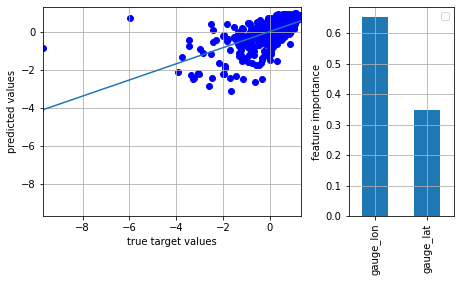

In [19]:
# Make a dictionary for all the X, y values
regressor_attributes = ['gauge_lat', 'gauge_lon']
feature_list_short = []
target='nse_sim'
ynormal = True
X, y = set_X_y(df, regressor_attributes, target, xnormal=True, ynormal=ynormal)

kf = KFold(n_splits=20, shuffle=True)
y_hat, rmse, r2, feature_importance = cross_val_rf(X,y,regressor_attributes,kf,
                ynormal=ynormal, n_estimators=1000,random_state=100,
                criterion='mse', min_samples_leaf=1, min_samples_split=2, max_depth=None,
                min_weight_fraction_leaf=0)

Overall rmse for the out-of-sample predictions: 0.86
Overall r^2 for the out-of-sample predictions: 0.27
RMSE Value stats for cross validation
mean = 0.77,  median = 0.65, stdev = 0.40, min = 0.34, max = 2.01
R-squared Value stats for cross validation
mean = 0.35,  median = 0.37, stdev = 0.20, min = 0.02, max = 0.80


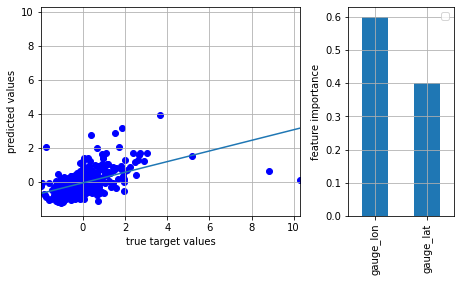

In [20]:
# Make a dictionary for all the X, y values
regressor_attributes = ['gauge_lat', 'gauge_lon']
feature_list_short = []
target='nse_da-sim'
ynormal = True
X, y = set_X_y(df, regressor_attributes, target, xnormal=True, ynormal=ynormal)

kf = KFold(n_splits=20, shuffle=True)
y_hat, rmse, r2, feature_importance = cross_val_rf(X,y,regressor_attributes,kf,
                ynormal=ynormal, n_estimators=1000,random_state=100,
                criterion='mse', min_samples_leaf=1, min_samples_split=2, max_depth=None,
                min_weight_fraction_leaf=0)

Overall rmse for the out-of-sample predictions: 0.91
Overall r^2 for the out-of-sample predictions: 0.20
RMSE Value stats for cross validation
mean = 0.82,  median = 0.69, stdev = 0.40, min = 0.38, max = 1.90
R-squared Value stats for cross validation
mean = 0.31,  median = 0.29, stdev = 0.22, min = 0.00, max = 0.74


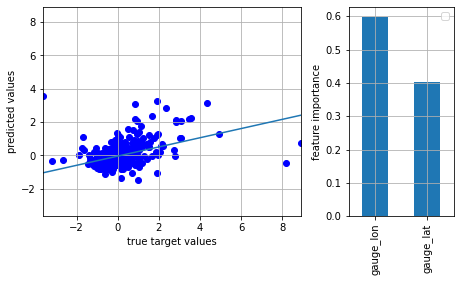

In [23]:
# Make a dictionary for all the X, y values
regressor_attributes = ['gauge_lat', 'gauge_lon']
feature_list_short = []
target='nse_ar-sim'
ynormal = True
X, y = set_X_y(df, regressor_attributes, target, xnormal=True, ynormal=ynormal)

kf = KFold(n_splits=20, shuffle=True)
y_hat, rmse, r2, feature_importance = cross_val_rf(X,y,regressor_attributes,kf,
                ynormal=ynormal, n_estimators=1000,random_state=100,
                criterion='mse', min_samples_leaf=1, min_samples_split=2, max_depth=None,
                min_weight_fraction_leaf=0)

Overall rmse for the out-of-sample predictions: 1.04
Overall r^2 for the out-of-sample predictions: 0.03
RMSE Value stats for cross validation
mean = 0.95,  median = 0.88, stdev = 0.41, min = 0.46, max = 1.93
R-squared Value stats for cross validation
mean = 0.13,  median = 0.06, stdev = 0.17, min = 0.00, max = 0.59


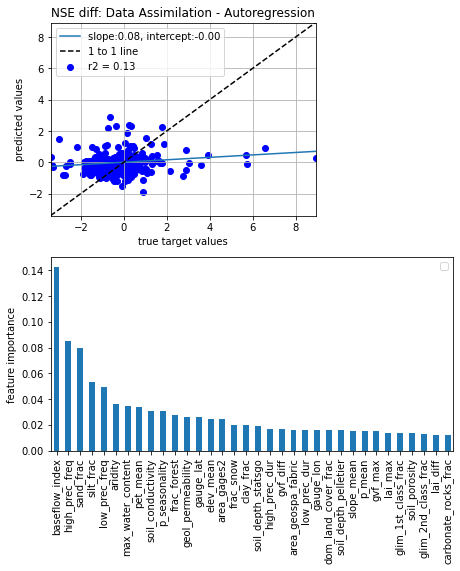

In [134]:
regressor_attributes = df.columns.values[:-6]

target='nse_da-ar'
ynormal = True
X, y = set_X_y(df, regressor_attributes, target, xnormal=True, ynormal=ynormal)

kf = KFold(n_splits=20, shuffle=True)
y_hat, rmse, r2, feature_importance = cross_val_rf(X,y,regressor_attributes,kf,
                ynormal=ynormal, n_estimators=1000,random_state=100,
                criterion='mse', min_samples_leaf=1, min_samples_split=2, max_depth=None,
                min_weight_fraction_leaf=0, title='NSE diff: Data Assimilation - Autoregression',
                filename='corr_diff_da_ar.pdf')

Overall rmse for the out-of-sample predictions: 0.83
Overall r^2 for the out-of-sample predictions: 0.32
RMSE Value stats for cross validation
mean = 0.74,  median = 0.62, stdev = 0.37, min = 0.39, max = 1.67
R-squared Value stats for cross validation
mean = 0.46,  median = 0.54, stdev = 0.21, min = 0.08, max = 0.77


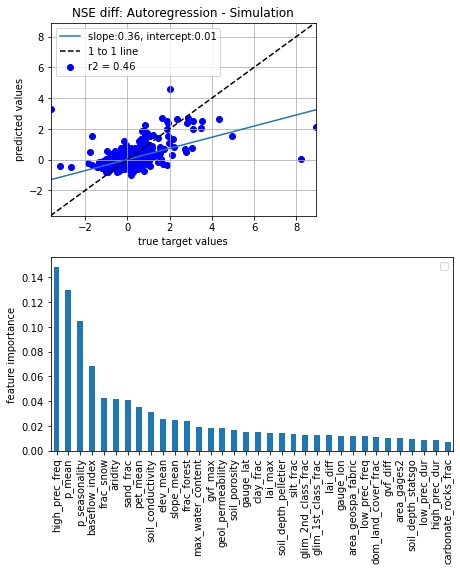

In [135]:
regressor_attributes = df.columns.values[:-6]

target='nse_ar-sim'
ynormal = True
X, y = set_X_y(df, regressor_attributes, target, xnormal=True, ynormal=ynormal)

kf = KFold(n_splits=20, shuffle=True)
y_hat, rmse, r2, feature_importance = cross_val_rf(X,y,regressor_attributes,kf,
                ynormal=ynormal, n_estimators=1000,random_state=100,
                criterion='mse', min_samples_leaf=1, min_samples_split=2, max_depth=None,
                min_weight_fraction_leaf=0, title='NSE diff: Autoregression - Simulation',
                filename='corr_diff_ar_sim.pdf')

Overall rmse for the out-of-sample predictions: 0.79
Overall r^2 for the out-of-sample predictions: 0.38
RMSE Value stats for cross validation
mean = 0.70,  median = 0.56, stdev = 0.35, min = 0.44, max = 1.86
R-squared Value stats for cross validation
mean = 0.48,  median = 0.55, stdev = 0.20, min = 0.01, max = 0.73


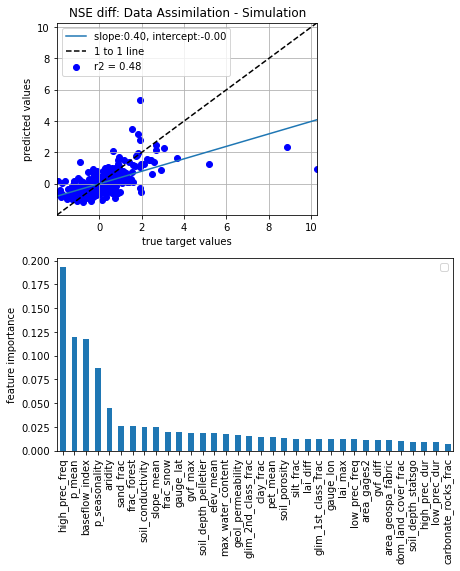

In [136]:
regressor_attributes = df.columns.values[:-6]

target='nse_da-sim'
ynormal = True
X, y = set_X_y(df, regressor_attributes, target, xnormal=True, ynormal=ynormal)

kf = KFold(n_splits=20, shuffle=True)
y_hat, rmse, r2, feature_importance = cross_val_rf(X,y,regressor_attributes,kf,
                ynormal=ynormal, n_estimators=1000,random_state=100,
                criterion='mse', min_samples_leaf=1, min_samples_split=2, max_depth=None,
                min_weight_fraction_leaf=0, title='NSE diff: Data Assimilation - Simulation',
                filename='corr_diff_da_sim.pdf')

Overall rmse for the out-of-sample predictions: 0.69
Overall r^2 for the out-of-sample predictions: 0.53
RMSE Value stats for cross validation
mean = 0.63,  median = 0.58, stdev = 0.28, min = 0.42, max = 1.71
R-squared Value stats for cross validation
mean = 0.58,  median = 0.58, stdev = 0.14, min = 0.38, max = 0.82


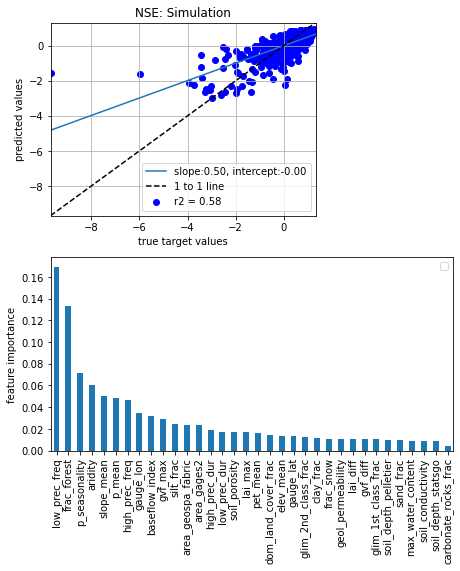

In [137]:
# Make a dictionary for all the X, y values
regressor_attributes = df.columns.values[:-6]
feature_list_short = []
target='nse_sim'
ynormal = True
X, y = set_X_y(df, regressor_attributes, target, xnormal=True, ynormal=ynormal)

kf = KFold(n_splits=20, shuffle=True)
y_hat, rmse, r2, feature_importance = cross_val_rf(X,y,regressor_attributes,kf,
                ynormal=ynormal, n_estimators=1000,random_state=100,
                criterion='mse', min_samples_leaf=1, min_samples_split=2, max_depth=None,
                min_weight_fraction_leaf=0, title='NSE: Simulation',
                filename='corr_simulation.pdf')

Overall rmse for the out-of-sample predictions: 0.63
Overall r^2 for the out-of-sample predictions: 0.61
RMSE Value stats for cross validation
mean = 0.61,  median = 0.58, stdev = 0.14, min = 0.42, max = 0.93
R-squared Value stats for cross validation
mean = 0.63,  median = 0.63, stdev = 0.13, min = 0.36, max = 0.80


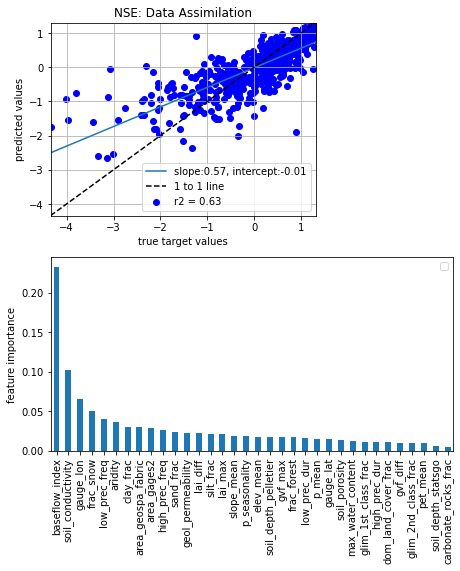

In [138]:
# Make a dictionary for all the X, y values
regressor_attributes = df.columns.values[:-6]
feature_list_short = []
target='nse_da'
ynormal = True
X, y = set_X_y(df, regressor_attributes, target, xnormal=True, ynormal=ynormal)

kf = KFold(n_splits=20, shuffle=True)
y_hat, rmse, r2, feature_importance = cross_val_rf(X,y,regressor_attributes,kf,
                ynormal=ynormal, n_estimators=1000,random_state=100,
                criterion='mse', min_samples_leaf=1, min_samples_split=2, max_depth=None,
                min_weight_fraction_leaf=0, title='NSE: Data Assimilation',
                filename='corr_data_assimilation.pdf')

Overall rmse for the out-of-sample predictions: 0.65
Overall r^2 for the out-of-sample predictions: 0.58
RMSE Value stats for cross validation
mean = 0.60,  median = 0.51, stdev = 0.24, min = 0.34, max = 1.37
R-squared Value stats for cross validation
mean = 0.65,  median = 0.69, stdev = 0.15, min = 0.27, max = 0.85


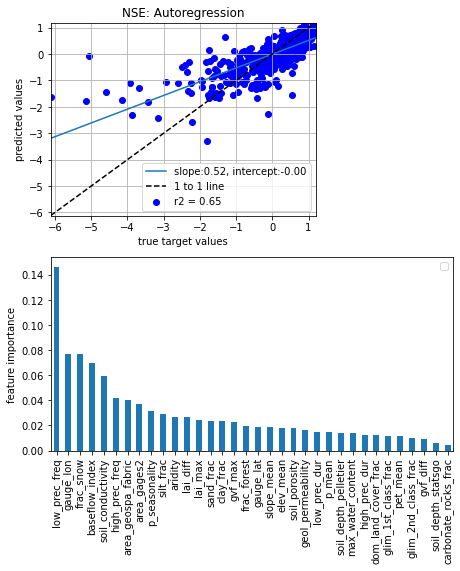

In [139]:
# Make a dictionary for all the X, y values
regressor_attributes = df.columns.values[:-6]
feature_list_short = []
target='nse_ar'
ynormal = True
X, y = set_X_y(df, regressor_attributes, target, xnormal=True, ynormal=ynormal)

kf = KFold(n_splits=20, shuffle=True)
y_hat, rmse, r2, feature_importance = cross_val_rf(X,y,regressor_attributes,kf,
                ynormal=ynormal, n_estimators=1000,random_state=100,
                criterion='mse', min_samples_leaf=1, min_samples_split=2, max_depth=None,
                min_weight_fraction_leaf=0, title='NSE: Autoregression',
                filename='corr_autoregression.pdf')

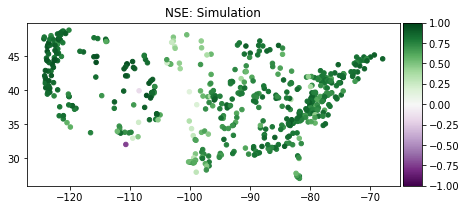

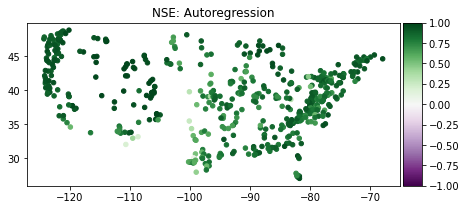

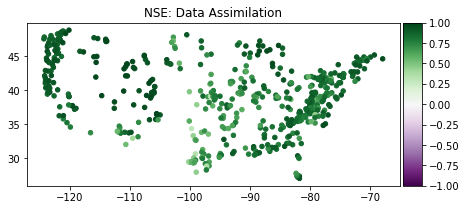

In [91]:
model_label_map = {'nse_da':'Data Assimilation', 'nse_ar':'Autoregression', 'nse_sim':'Simulation'}
for model in ['nse_sim', 'nse_ar', 'nse_da']:
    gs = plt.GridSpec(1, 10, wspace=0.33333)
    fig = plt.figure(figsize=(12, 3))
    ax0 = fig.add_subplot(gs[0,:6])
    im = ax0.scatter(plot_lons, plot_lats,
                    c=df.loc[:,model],
                    s=20,
                    cmap='PRGn',
                    vmin=-1, vmax=1)
    ax0.set_title('NSE: {}'.format(model_label_map[model]))
    clims = im.get_clim()
    
    # colorbar
    divider = make_axes_locatable(ax0)
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(im, cax=cax, orientation='vertical')


/home/jmframe/programs/anaconda3/envs/mc-paper/lib/python3.7/site-packages/ipykernel_launcher.py:36: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


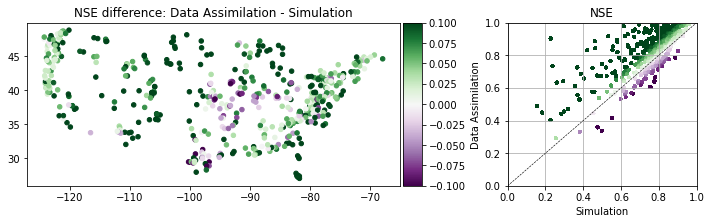

/home/jmframe/programs/anaconda3/envs/mc-paper/lib/python3.7/site-packages/ipykernel_launcher.py:36: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


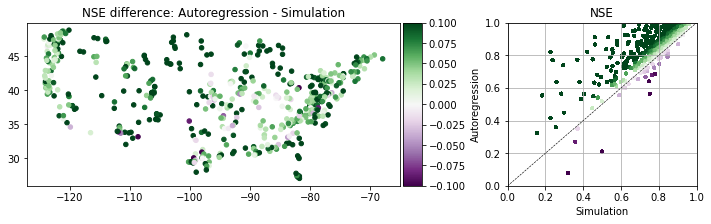

In [125]:

test_model_label_map = {'nse_da':'Data Assimilation', 'nse_ar':'Autoregression'}

for test_model in ['nse_da', 'nse_ar']:
    
    gs = plt.GridSpec(1, 10, wspace=0.33333)
    fig = plt.figure(figsize=(12, 3))
    ax0 = fig.add_subplot(gs[0,:6])
    im = ax0.scatter(plot_lons, plot_lats,
                    c=df.loc[:,test_model+'-sim'],
                    s=20,
                    cmap='PRGn',
                    vmin=-.1, vmax=.1)
    ax0.set_title('NSE difference: {} - Simulation'.format(test_model_label_map[test_model]))
    clims = im.get_clim()

    # colorbar
    divider = make_axes_locatable(ax0)
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(im, cax=cax, orientation='vertical')

    ax1 = fig.add_subplot(gs[0,7:])
    ax1.plot([0, 1],[0,1], 'k--', lw=0.6)
    for b, basin in enumerate(basin_list):
        basin_color = im.to_rgba(df.loc[:,test_model+'-sim'])
        ax1.scatter(df.loc[:,'nse_sim'],
                    df.loc[:,test_model],
                    s=5,
                    color=basin_color)
    ax1.set_title('NSE')
    ax1.set_xlabel('Simulation')
    ax1.set_ylabel(test_model_label_map[test_model])
    ax1.set_xlim([0,1])
    ax1.set_ylim([0,1])
    ax1.grid()

    plt.tight_layout()
    plt.show()
    fig.savefig('./figs/map_'+test_model+'.pdf', dpi=600)
    plt.close()